In [1]:
import sys

import jax.numpy as np
import optax
from jax import jit, vmap

from base_network import neural_network
from plotutils import plot_losses, plot_domain, plot_poisson
from poisson.poisson_utils import (
    boundary_loss_factory,
    interior_loss_factory,
    interface_loss_factory,
)
from utils import data_path
from xpinn import XPINN

## Initializing the PINN

In [3]:
# Set files
name = str(sys.argv[1])
file = data_path / "poisson_train.json"
file_test = data_path / "poisson_test.json"
activation = np.tanh

save_path = data_path.parent / "figures/Poisson"

In [4]:
# Set model (FFNN)
xpinn = XPINN(file, activation)
model = neural_network(activation)
v_model = vmap(model, (None, 0))

We visualize the points of the domain decomposition.

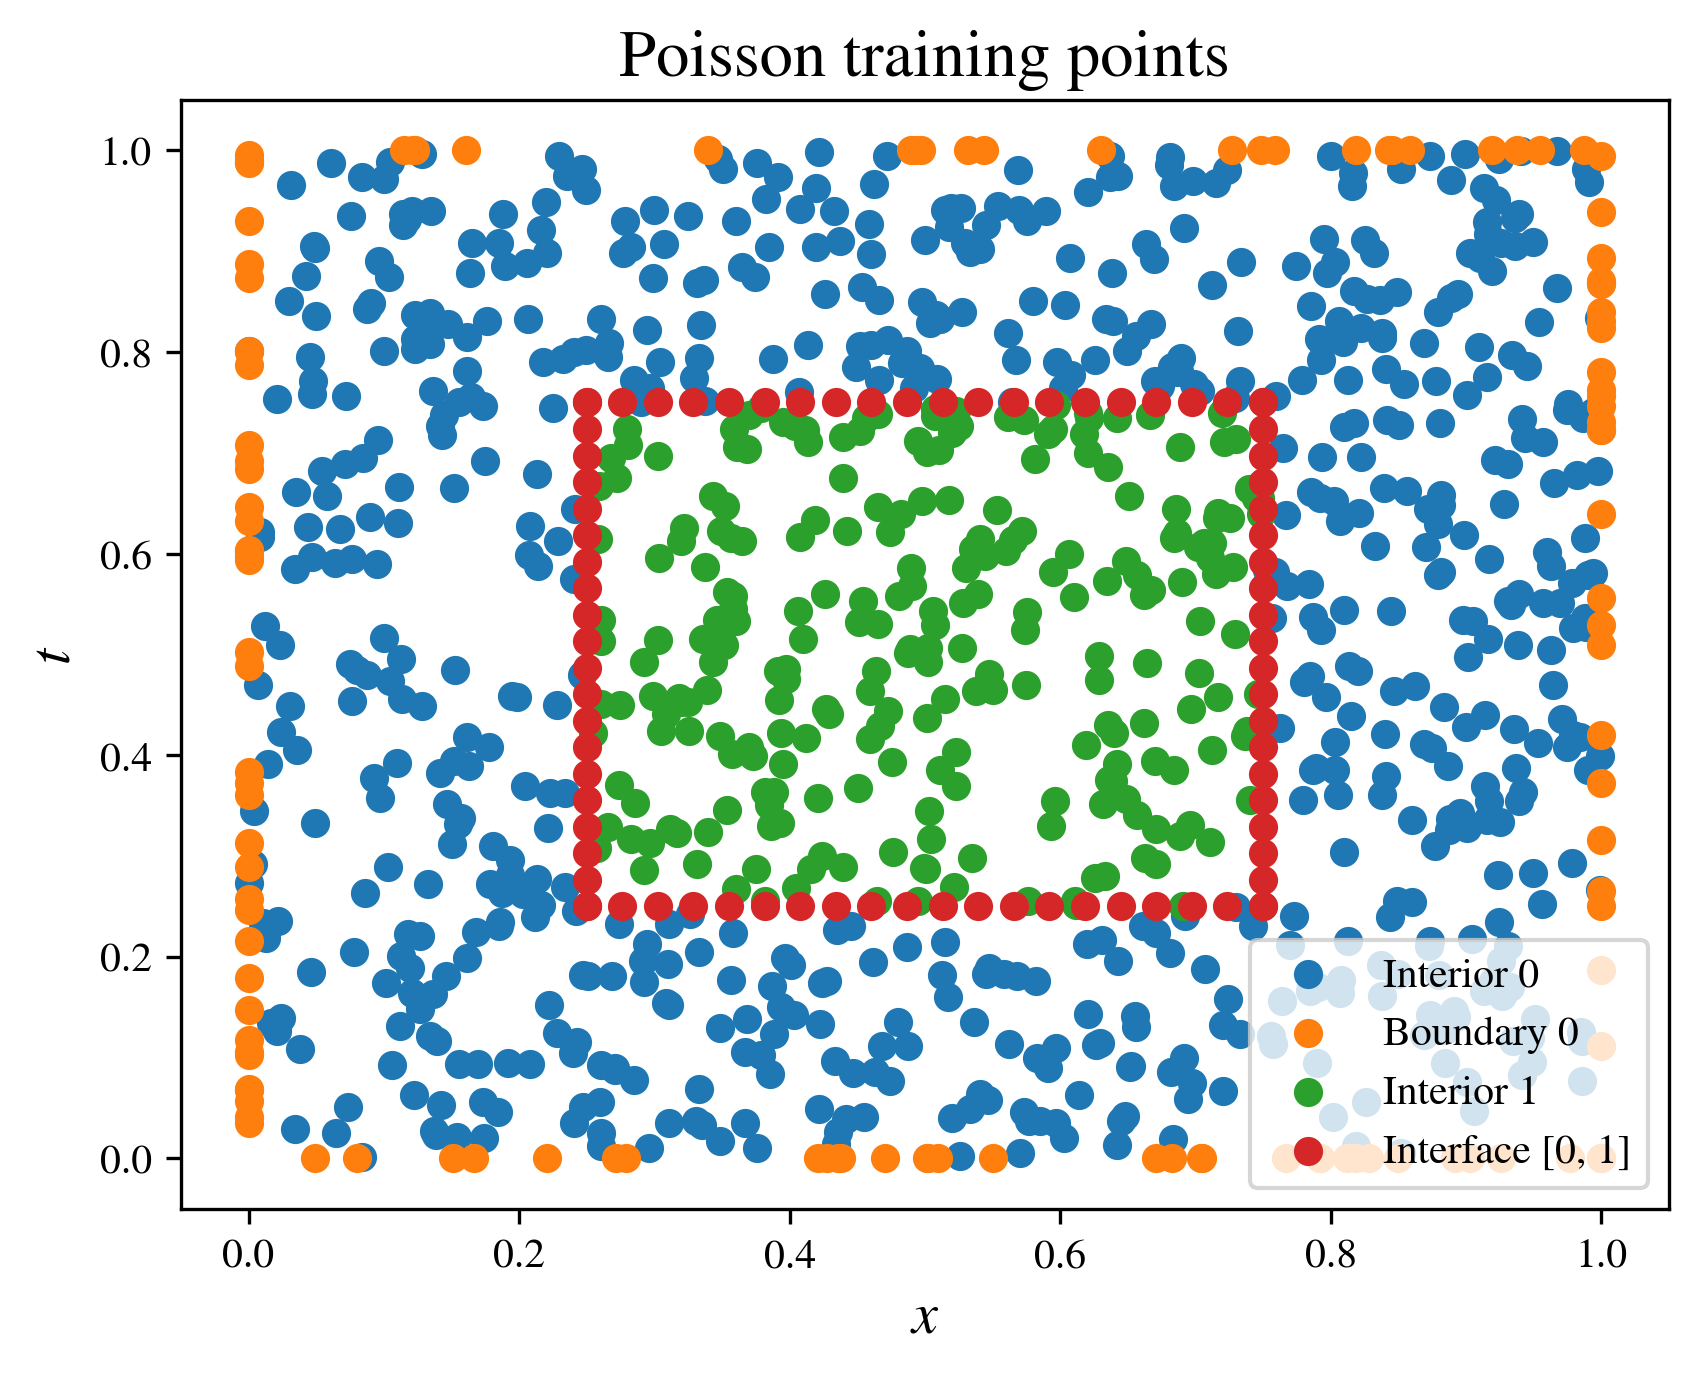

In [5]:
plot_domain(
    xpinn,
    savepath=save_path,
    title="Poisson training points",
    save_name="poisson_train_points.pdf",
)

### PINN Formalization
We only consider boundary loss for the outer PINN.

### Setting the true solution

In [6]:
# Set true solution and RHS
@jit
def u_star(x):
    return np.prod(np.sin(np.pi * x))


# rhs
@jit
def f(x):
    return 2.0 * np.pi**2 * u_star(x)

f_v = f
f_final = jit(f_v)

### Setting the loss function

In [7]:
# Set losses
p0, p1 = xpinn.PINNs
p0.boundary_loss = boundary_loss_factory(p0, 0.0)
p0.interior_loss = interior_loss_factory(p0, f)  # implementing rhs
p1.interior_loss = interior_loss_factory(p1, f)
p0.interface_loss = interface_loss_factory(xpinn, 0, 1)
p1.interface_loss = interface_loss_factory(xpinn, 1, 0)

Initializing the optimizer

In [10]:
# Initializing optimizer
shapes = [[2] + [64] + [1]] * 2
exponential_decay = optax.exponential_decay(
    init_value=0.001,
    transition_steps=10000,
    transition_begin=15000,
    decay_rate=0.1,
    end_value=0.0000001,
)
optimizer = optax.adam(learning_rate=exponential_decay)
xpinn.initialize_params(shapes, optimizer)

In [11]:
# Setting iterations
n_iter = 200000
xpinn.set_loss()
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 200000: Total loss = 301.9469909667969
10.00% iter = 20000 of 200000: Total loss = 0.0015866896719671786
20.00% iter = 40000 of 200000: Total loss = 0.0007087951235007495
30.00% iter = 60000 of 200000: Total loss = 0.0006311533797997981
40.00% iter = 80000 of 200000: Total loss = 0.0006157955212984234
50.00% iter = 100000 of 200000: Total loss = 0.0006007387128192931
60.00% iter = 120000 of 200000: Total loss = 0.0005860127275809646
70.00% iter = 140000 of 200000: Total loss = 0.0005716292653232813
80.00% iter = 160000 of 200000: Total loss = 0.0005575249815592542
90.00% iter = 180000 of 200000: Total loss = 0.0005436642677523196
100.00% iter = 200000 of 200000: Total loss = 0.0005299769836710766


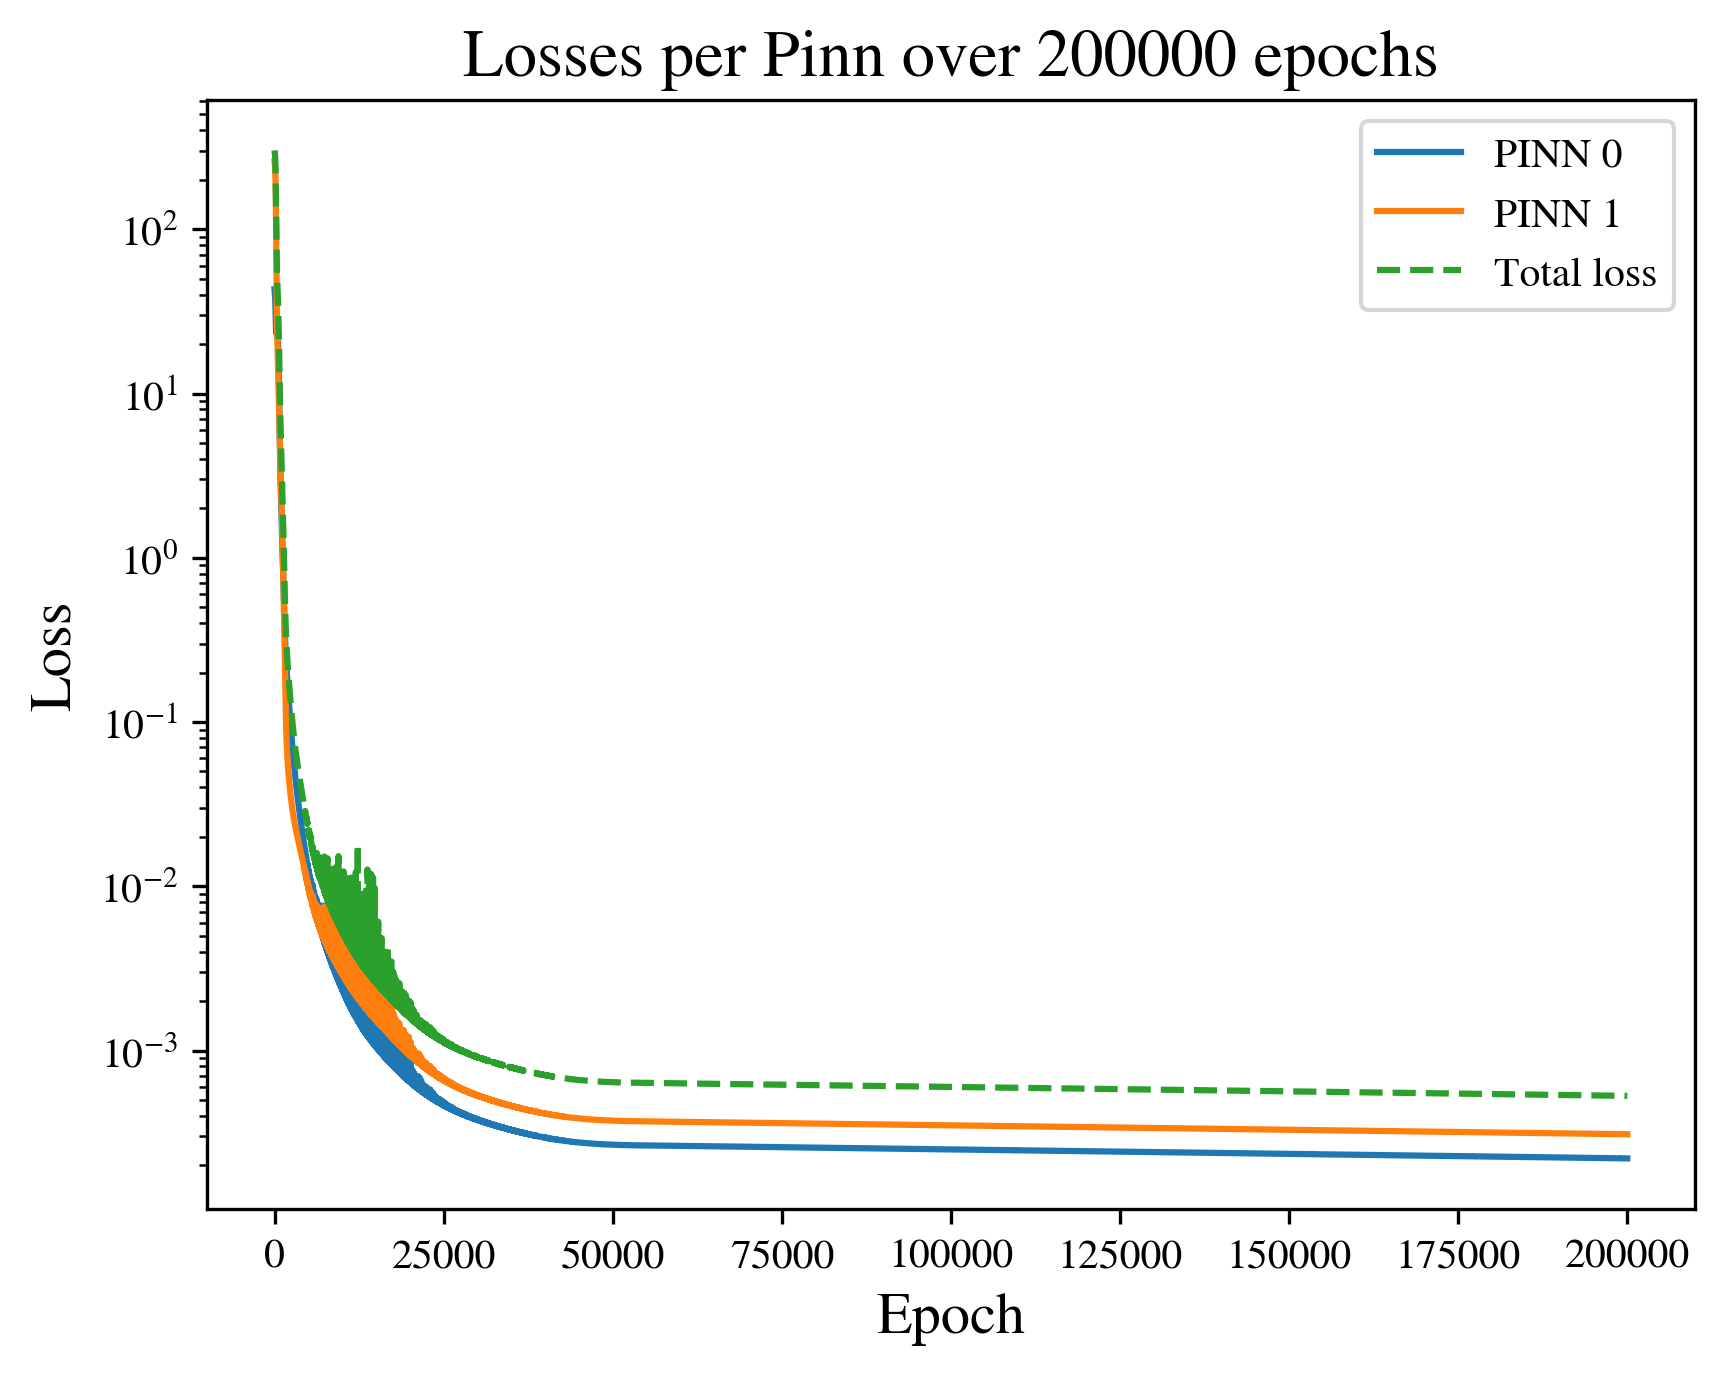

In [19]:
plot_losses(
    losses,
    savepath=save_path,
    save_name="smooth_xpinn_Poisson_losses.pdf",
    n_iter=n_iter,
    title=f"Losses per Pinn over {n_iter} epochs",
)

In [13]:
points, predictions = xpinn.predict(file_test)
total_points = np.concatenate(points)
total_pred = np.concatenate(predictions)

true_value = (
    np.sin(np.pi * total_points[:, 0]) * np.sin(np.pi * total_points[:, 1])
).reshape(-1, 1)

In [14]:
print(true_value.shape, total_pred.shape, total_points.shape)

(996004, 1) (996004, 1) (996004, 2)


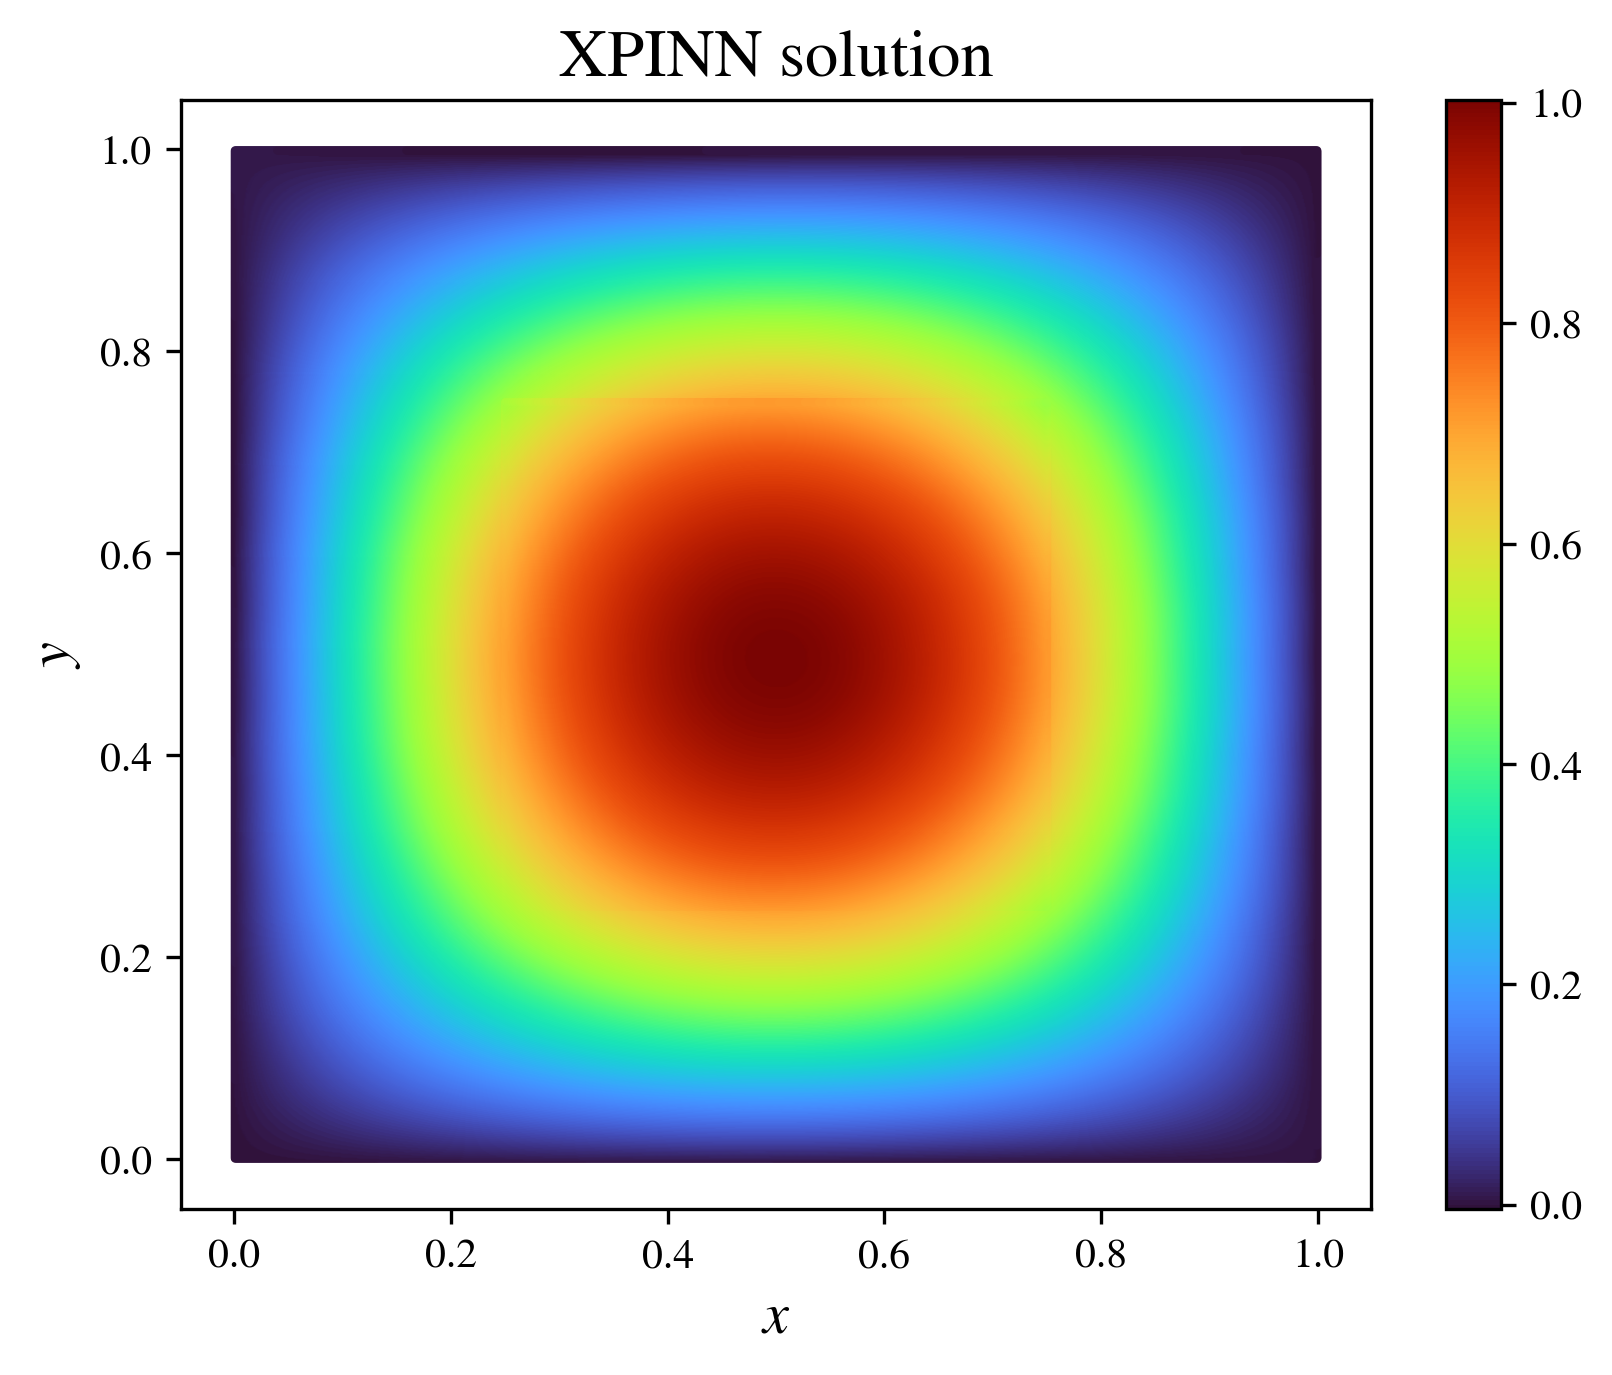

In [15]:
plot_poisson(
    total_points,
    total_pred,
    savepath=save_path,
    title="XPINN solution",
    save_name="smooth_xpinn_Poisson_solution",
)

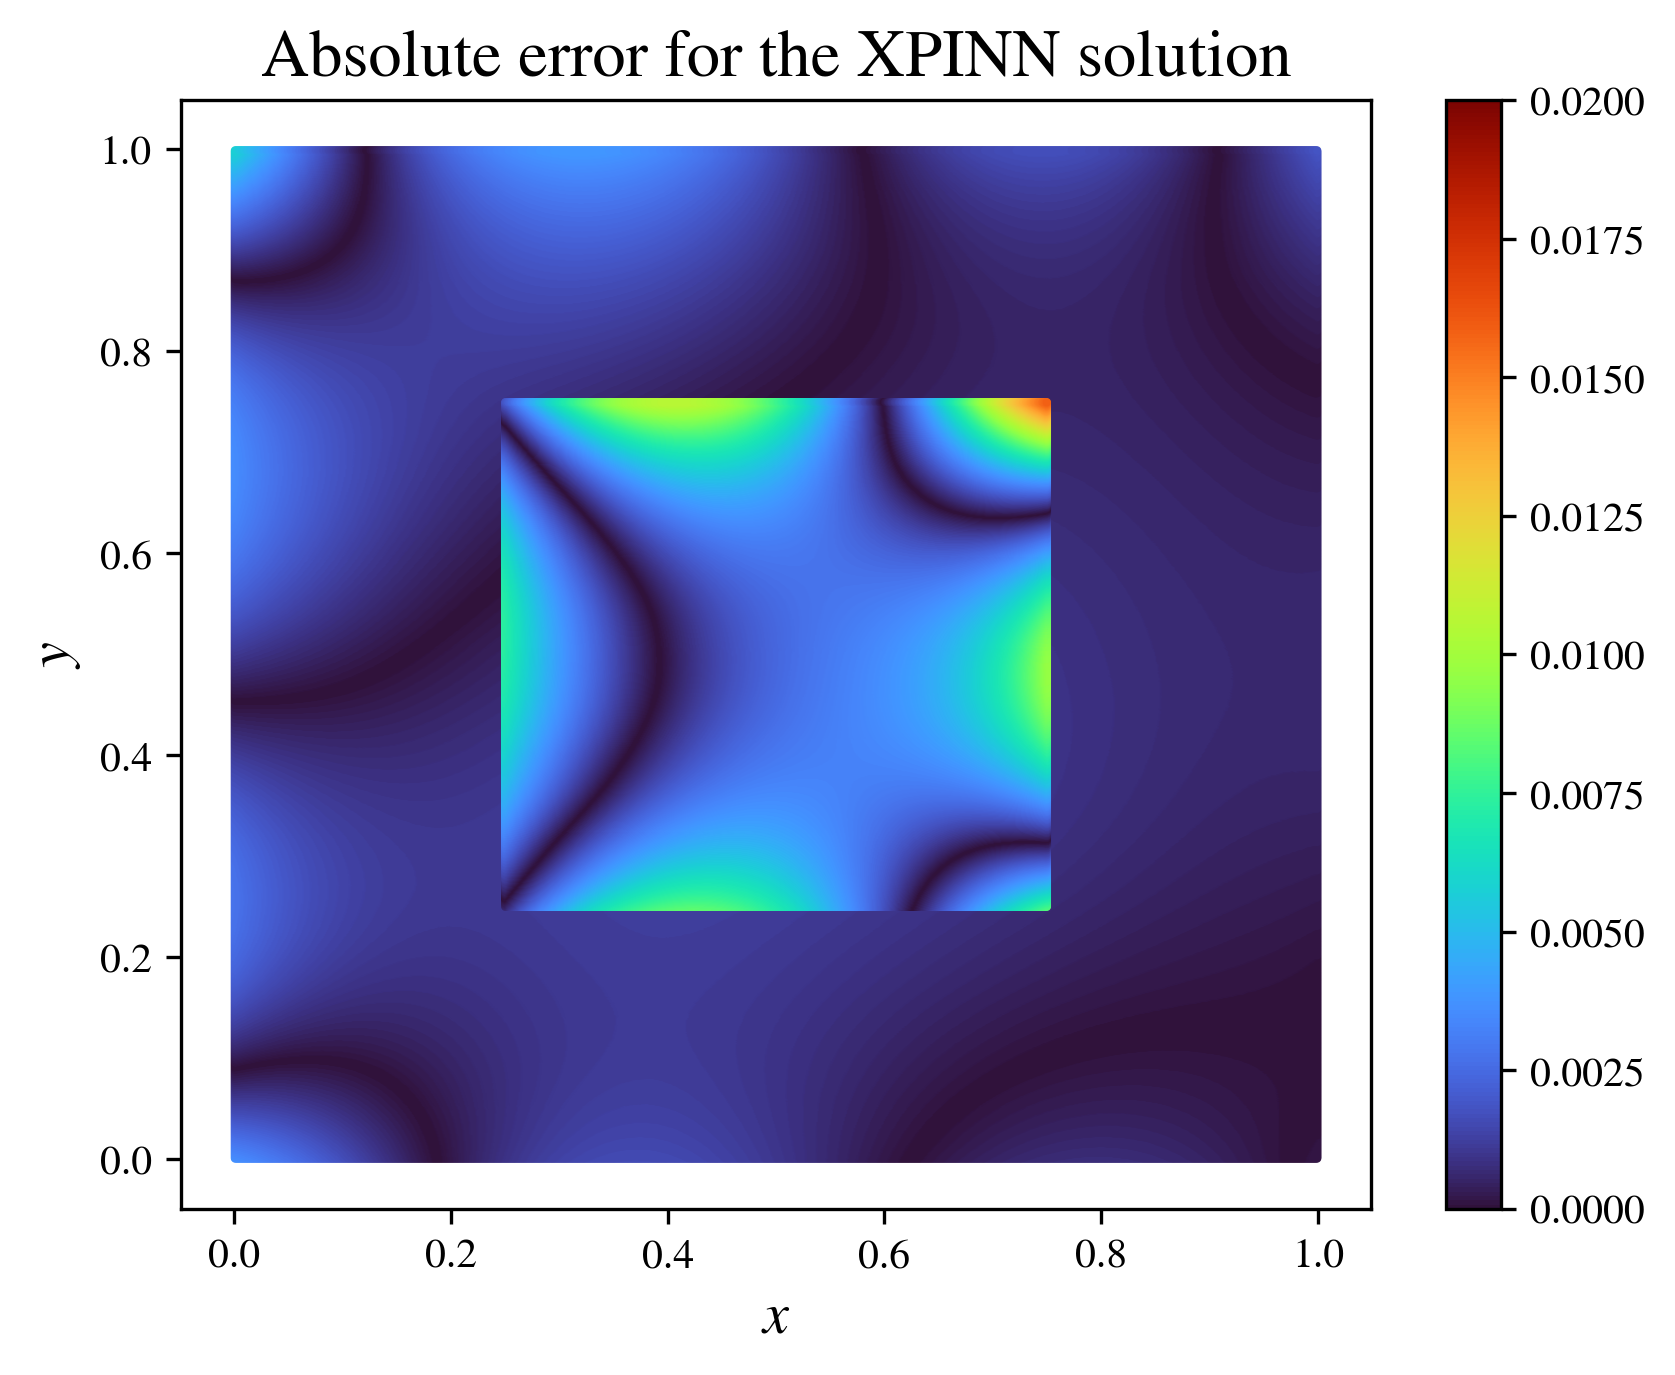

In [16]:
error = np.abs(total_pred - true_value)

plot_poisson(
    total_points,
    error,
    savepath=save_path,
    title="Absolute error for the XPINN solution",
    save_name="smooth_xpinn_Poisson_error",
    clim=(0, 0.02),
)